In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import pandas as pd

%matplotlib inline

## Regex Matching

In [2]:
LOG_REGEX = re.compile(r'INFO:root:([A-Za-z_0-9=+ ]+): benchmarks\/data\/test-data-([0-9]+)-([0-9]+)\.csv; Size: ([0-9]+) bytes; time: ([0-9.]+)s')
group_dict = lambda matched: {
    'name': matched.group(1),
    'rows': int(matched.group(2)),
    'cols': int(matched.group(3)),
    'bytes': int(matched.group(4)),
    'time': float(matched.group(5))
}

JOIN_REGEX = re.compile(r'INFO:root:([A-Za-z_0-9=+ ]+): benchmarks\/data\/test-data-([0-9]+)-([0-9]+)\.csv & benchmarks\/data\/test-data-([0-9]+)-([0-9]+)\.csv; Left Size: ([0-9]+) bytes; Right Size: ([0-9]+) bytes; time: ([0-9.]+)s')
join_group_dict = lambda matched: {
    'name': matched.group(1),
    'rows-left': int(matched.group(2)),
    'cols-left': int(matched.group(3)),
    'rows-right': int(matched.group(4)),
    'cols-right': int(matched.group(5)),
    'bytes-left': int(matched.group(6)),
    'bytes-right': int(matched.group(7)),
    'time': float(matched.group(8)),
    'size-left': matched.group(2) + " x " + matched.group(3),
    'size-right': matched.group(4) + " x " + matched.group(5)
}

## Parsing

In [3]:
modin_files = glob.glob('../../benchmark-results/modin-*.log')
pandas_files = glob.glob('../../benchmark-results/pandas-*.log')

In [4]:
modin_results = {}
for filename in modin_files:
    with open(filename) as f:
        for line in f:
            m = re.search(LOG_REGEX, line)
            if m is None:
                continue
            data = group_dict(m)
            if data['name'] not in modin_results:
                modin_results[data['name']] = {}
            if data['bytes'] not in modin_results[data['name']]:
                modin_results[data['name']][data['bytes']] = []
            modin_results[data['name']][data['bytes']].append(data['time'])

    for k in modin_results:
        for k2 in modin_results[k]:
            modin_results[k][k2] = np.mean(modin_results[k][k2])

In [5]:
pandas_results = {}
for filename in pandas_files:
    with open(filename) as f:
        for line in f:
            m = re.search(LOG_REGEX, line)
            if m is None:
                continue
            data = group_dict(m)
            if data['name'] not in pandas_results:
                pandas_results[data['name']] = {}
            if data['bytes'] not in pandas_results[data['name']]:
                pandas_results[data['name']][data['bytes']] = []
            pandas_results[data['name']][data['bytes']].append(data['time'])

    for k in pandas_results:
        for k2 in pandas_results[k]:
            pandas_results[k][k2] = np.mean(pandas_results[k][k2])

In [6]:
for op in pandas_results.keys():
    modin_data = modin_results[op]
    modin_x = modin_data.keys()
    modin_y = [modin_data[k] for k in modin_x]
    modin_x = [x/1024/1024 for x in modin_x] # convert to MB

    pandas_data = pandas_results[op]
    pandas_x = pandas_data.keys()
    pandas_y = [pandas_data[k] for k in pandas_x]
    pandas_x = [x/1024/1024 for x in pandas_x]

    plt.scatter(pandas_x, pandas_y, c='b', label='pandas')
    plt.scatter(modin_x, modin_y, c='r', label='modin')
    plt.legend(loc='upper left')
    plt.title(op)
    plt.xlabel('Data Size (MB)')
    plt.ylabel('Time taken (s)')
    plt.savefig(op.replace(" ", "_") + ".png", dpi=500)
    plt.close()

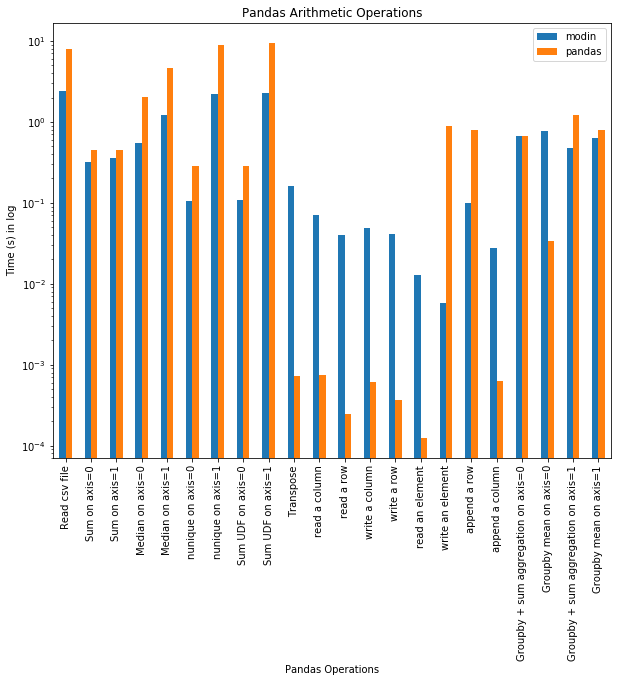

In [7]:
pandas_data = {}
modin_data = {}
for op in pandas_results.keys():
    pandas_op_data = pandas_results[op]
    modin_op_data = modin_results[op]
    common_data_sizes = set.intersection(set(pandas_op_data.keys()), set(modin_op_data.keys()))

    pandas_data[op] = np.mean([pandas_op_data[k] for k in common_data_sizes])
    modin_data[op] = np.mean([modin_op_data[k] for k in common_data_sizes])

keys = list(pandas_data.keys())
df = pd.DataFrame({
    'Pandas Operations': keys,
    'pandas': [pandas_data[k] for k in keys],
    'modin': [modin_data[k] for k in keys]
}).set_index('Pandas Operations', drop=True)

df.plot(kind='bar', logy=True, figsize=(10,8))
plt.title("Pandas Arithmetic Operations")
plt.ylabel("Time (s) in log")
plt.savefig('arithmetic_operations.png', dpi=500)

## JOIN Data

In [8]:
modin_results = {}
for filename in modin_files:
    with open(filename) as f:
        for line in f:
            m = re.search(JOIN_REGEX, line)
            if m is None:
                continue
            data = join_group_dict(m)
            if data['name'] not in modin_results:
                modin_results[data['name']] = {}
            if (data['bytes-left'], data['bytes-right']) not in modin_results[data['name']]:
                modin_results[data['name']][(data['bytes-left'], data['bytes-right'])] = []
            modin_results[data['name']][(data['bytes-left'], data['bytes-right'])].append(data['time'])

    for k in modin_results:
        for k2 in modin_results[k]:
            modin_results[k][k2] = np.mean(modin_results[k][k2])

In [9]:
pandas_results = {}
for filename in pandas_files:
    with open(filename) as f:
        for line in f:
            m = re.search(JOIN_REGEX, line)
            if m is None:
                continue
            data = join_group_dict(m)
            if data['name'] not in pandas_results:
                pandas_results[data['name']] = {}
            if (data['bytes-left'], data['bytes-right']) not in pandas_results[data['name']]:
                pandas_results[data['name']][(data['bytes-left'], data['bytes-right'])] = []
            pandas_results[data['name']][(data['bytes-left'], data['bytes-right'])].append(data['time'])

    for k in pandas_results:
        for k2 in pandas_results[k]:
            pandas_results[k][k2] = np.mean(pandas_results[k][k2])

In [23]:
plot_data = {}
for k, v in inner_join_df_groupby:
    plot_data[k] = {'inner join': v}
for k, v in outer_join_df_groupby:
    if k not in plot_data:
        plot_data[k] = {}
    plot_data[k]['outer join'] = v
for k, v in inner_merge_df_groupby:
    if k not in plot_data:
        plot_data[k] = {}
    plot_data[k]['inner merge'] = v
for k, v in outer_merge_df_groupby:
    if k not in plot_data:
        plot_data[k] = {}
    plot_data[k]['outer merge'] = v

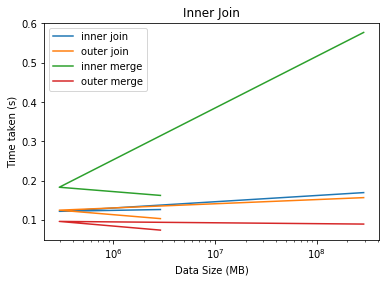

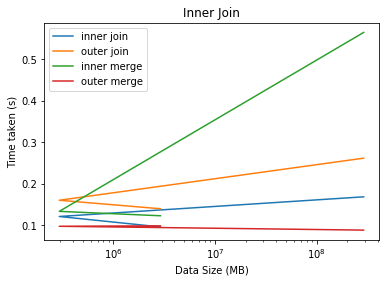

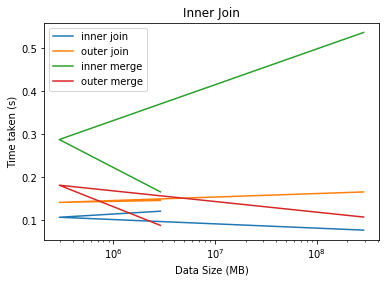

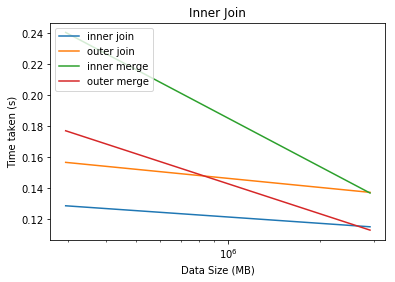

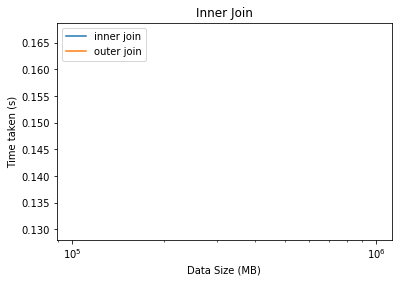

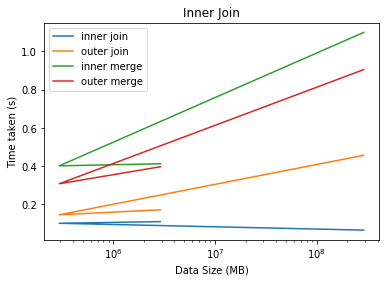

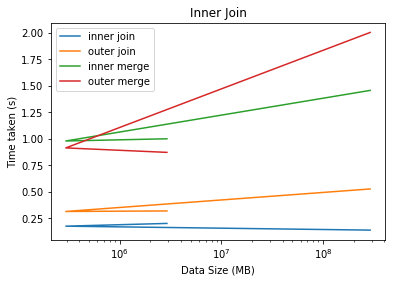

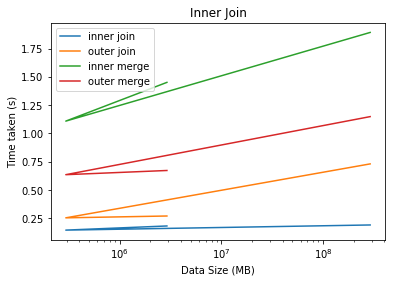

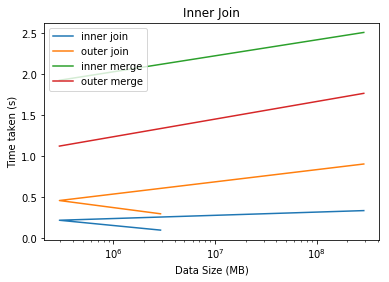

In [22]:
for left_size in plot_data:
    for join in plot_data[left_size]:
        plt.plot(plot_data[left_size][join]['right-size'],
                    plot_data[left_size][join]['performance'],
                    label=join)
    plt.legend(loc='upper left')
    plt.title(op)
    plt.xlabel('Data Size (MB)')
    plt.ylabel('Time taken (s)')
    plt.gca().set_xscale('log')
    plt.show()
    # plt.savefig(op.replace(" ", "_") + ".png", dpi=500)
    # plt.close()